## Python读取GrADS的ctl二进制文件
**18 Febrary 2020 by MiniUFO**

---
[TOC]

---
### 1. 问题
用了python的[`xarray`](http://xarray.pydata.org/en/stable/)包后，特别喜欢它的数据接口，直接就可以读取自描述的[NetCDF](https://www.unidata.ucar.edu/software/netcdf/)（nc）文件，并且组织成一个`Dataset`。例如打开[`xarray`](http://xarray.pydata.org/en/stable/)自带的教学nc文件可以得到如下的`Dataset`：

In [1]:
import xarray as xr

dset = xr.tutorial.open_dataset('air_temperature')
dset

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

可以很清楚地看到nc文件的结构、变量、坐标、meta信息等等。

我以前是[GrADS/OpenGrADS](http://www.opengrads.org/)的重度用户，我也习惯使用[GrADS/OpenGrADS](http://www.opengrads.org/)和配套的二进制数据，通常是一个二进制文件配一个[.ctl](http://cola.gmu.edu/grads/gadoc/descriptorfile.html)（control，类似于nc的header信息）文件进行信息描述。所以现在开始学习python以后希望能用python直接解析ctl文件信息然后读取相应的二进制文件数据。解析ctl文件并不难，但是我希望能和[`xarray`](http://xarray.pydata.org/en/stable/)无缝连接，读取完数据返回一个`Dataset`，并且使用[`dask`](https://dask.org/)工具，做到数据在内存中的缓存和并行。

---

### 2. 解决方法
首先，编写了一个[xgrads](https://github.com/miniufo/xgrads)包，里面用`CtlDescriptor`类来代表.ctl文件，使用如下：

In [1]:
import sys
sys.path.append('../../')
from xgrads.core import CtlDescriptor


ctl = CtlDescriptor(file='../ctls/test8.ctl')

print(ctl)

   dsetPath: ['../ctls/test8_2013010100.dat' '../ctls/test8_2013010106.dat'
 '../ctls/test8_2013010112.dat' '../ctls/test8_2013010118.dat']
   descPath: ../ctls/test8.ctl
   indxPath: 
   stnmPath: 
      title: 
      undef: -9.99e+33
       zrev: False
       yrev: True
      dtype: 
   template: True
  periodicX: True
 cal365Days: False
 sequential: True
  byteOrder: True
       xdef: [200.  202.5 205.  207.5 210.  212.5 215.  217.5 220.  222.5 225.  227.5
 230.  232.5 235.  237.5 240.  242.5 245.  247.5 250.  252.5 255.  257.5
 260.  262.5 265.  267.5 270.  272.5 275.  277.5 280.  282.5 285.  287.5
 290.  292.5 295.  297.5 300.  302.5 305.  307.5 310.  312.5 315.  317.5
 320.  322.5 325.  327.5 330. ]
       ydef: [75.  72.5 70.  67.5 65.  62.5 60.  57.5 55.  52.5 50.  47.5 45.  42.5
 40.  37.5 35.  32.5 30.  27.5 25.  22.5 20.  17.5 15. ]
       zdef: [1000.]
       tdef: ['2013-01-01T00:00:00' '2013-01-01T06:00:00' '2013-01-01T12:00:00'
 '2013-01-01T18:00:00']
       vdef: [CtlVa

然后用这个类来构建一个`open_CtlDataset`函数，该函数和[`xarray.open_dataset`](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)一样返回`Dataset`：

In [2]:
from xgrads.core import open_CtlDataset

dset = open_CtlDataset('../ctls/test8.ctl')

dset

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 4)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-01-01T18:00:00
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
Data variables:
    air      (time, lat, lon) >f4 dask.array<chunksize=(1, 25, 53), meta=np.ndarray>
Attributes:
    title:    
    undef:    -9.99e+33

花了点时间去编写[`dask`](https://dask.org/)相关代码，所以这里返回的`Dataset`同样支持[`dask`](https://dask.org/)的`chunk`功能。同时也(部分)支持ctl的[template](http://cola.gmu.edu/grads/gadoc/templates.html)功能。这样python可以完美读取[GrADS/OpenGrADS](http://www.opengrads.org/)的ctl和对应的二进制文件，并且与[`xarray`](http://xarray.pydata.org/en/stable/)的功能无缝配合。比如读取变量并画图：

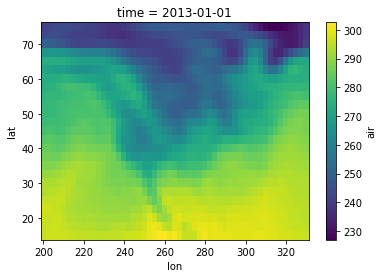

In [3]:
dset.air[0].plot()

### References
[https://dask.org/](https://dask.org/)

[http://xarray.pydata.org/en/stable/](http://xarray.pydata.org/en/stable/)